# Toy Experiments

In [1]:
import os, sys
sys.path.append("..")

from src import distributions

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from basic import ScoreNetwork

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from src.plotters import plot_results

from src.plotters import plot_trajectories

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [2]:
X_sampler = distributions.StandardNormalSampler(dim=2, device="cuda")
Y_sampler = distributions.SwissRollSampler(device="cuda")
# Y_sampler = distributions.Mix8GaussiansSampler(std=0.1, r=np.sqrt(2), device="cuda")

DIM = 2
H = 100

batch_size = 1000
lr = 1e-4
n_steps = 100
GAMMA = 0.0
G_ITERS = 50
D_ITERS = 1
f_ITERS = 3
MAX_STEPS = 5000


ZC = 1
Z_STD = 1.0

In [ ]:
def train(X_sampler, Y_sampler, f, f_opt, G, G_opt, D, D_opt, sde, plot_n_samples=500):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):
            
        for G_iter in range(G_ITERS):

            for f_iter in range(f_ITERS):
                x0 = X_sampler.sample(batch_size)
                xN = G(x0)
                
                t = (torch.rand(x0.shape[0])[:, None]*0.99).cuda()
                xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
                
                f_loss = ((f(xt, t) - (xN - xt)/(1-t)) ** 2).mean()
                f_opt.zero_grad(); f_loss.backward(); f_opt.step()

            x0 = X_sampler.sample(batch_size)
            xN = G(x0)

            t = (torch.rand(x0.shape[0])[:, None]*0.99).cuda()
            xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
            
            f_x_t = f(xt, t)
            E = (xN - xt)/(1-t)
            
            G_loss = (f_x_t*E).mean() - (f_x_t*f_x_t).mean()/2 - D(xN).mean()
            
            G_opt.zero_grad(); G_loss.backward(); G_opt.step()
        
        
        # plotter 1
        if step % 100 == 0:
            clear_output(wait=True)
            
            fig, axes = plot_trajectories(X_sampler, G, ZC, Z_STD, sde, k=10)
            plt.show()
            
            original_dataset = torch.cat(
                [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            X = X_sampler.sample(plot_n_samples)
            # G_dataset = G(X).detach().cpu()
            
            G_dataset = G(X).detach().cpu()
            f_dataset = sde(X).detach().cpu()

            G_mse.append(F.mse_loss(X.detach().cpu(), G_dataset).item())
            sde_mse.append(F.mse_loss(X.detach().cpu(), f_dataset).item())
            print('G mse:', G_mse[-1])
            print('sde mse:', sde_mse[-1])
            
            with torch.no_grad():
                X = X_sampler.sample(1000)

                T_XZ_np = []
                
                # Our method results G
                for i in range(100):
                    T_XZ_np.append(G(X).cpu().numpy())
            
                T_XZ_np = np.array(T_XZ_np)
                G_var.append(T_XZ_np.var(axis=0).mean(axis=0).mean().item())
                print('G var:', G_var[-1])

                T_X_np = []
                for i in range(100):
                    T_X_np.append(sde(X).cpu().numpy())
            
                T_X_np = np.array(T_X_np)
                sde_var.append(T_X_np.var(axis=0).mean(axis=0).mean().item())
                print('sde var:', sde_var[-1])
            
            
            plot_results(f_dataset, G_dataset, target_dataset)
            plt.show()
            
        for D_iter in range(D_ITERS):    
            x0 = X_sampler.sample(batch_size)
            x1 = Y_sampler.sample(batch_size)
            xN = G(x0)
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

    return (G_mse, G_var, sde_mse, sde_var)

## 4. Training

In [ ]:
f = ScoreNetwork().cuda()
    
class G(torch.nn.Module):
    def __init__(self, dim, zc, h, z_std):
        super().__init__()
        self.zc = zc
        self.z_std = z_std
        self.nn_ = nn.Sequential(
            nn.Linear(dim+zc, h),
            nn.ReLU(True), 
            nn.Linear(h, h),
            nn.ReLU(True),
            nn.Linear(h, h),
            nn.ReLU(True),
            nn.Linear(h, dim)
        )

    def forward(self, x):
        z = torch.randn(x.shape[0], self.zc, device=x.device) * self.z_std
        return self.nn_(torch.cat([x, z], axis = -1))


G = G(DIM, ZC, H, Z_STD).cuda()


D = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1)
).cuda()


f_opt = Adam(f.parameters(), lr=lr)
G_opt = Adam(G.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr)


class SDE(nn.Module):
    def __init__(self, shift_model, n_steps):
        super().__init__()
        self.shift_model = shift_model
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
    
    def forward(self, x0, traj = False):
        x, t = x0, 0.0
        trajectory = [x]
        for step in range(self.n_steps):
            batch_size = x.shape[0]
            x = x + self.delta_t*self.shift_model(x, torch.tensor(t).repeat(batch_size)[:, None].cuda()) + torch.randn_like(x)*np.sqrt(GAMMA*self.delta_t)
            t += self.delta_t
            trajectory.append(x)
        if traj:
            return x, trajectory
        return x
    

/tmp/ipykernel_118648/2756377946.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.s = torch.nn.Parameter(torch.tensor(torch.randn(1)[0]))


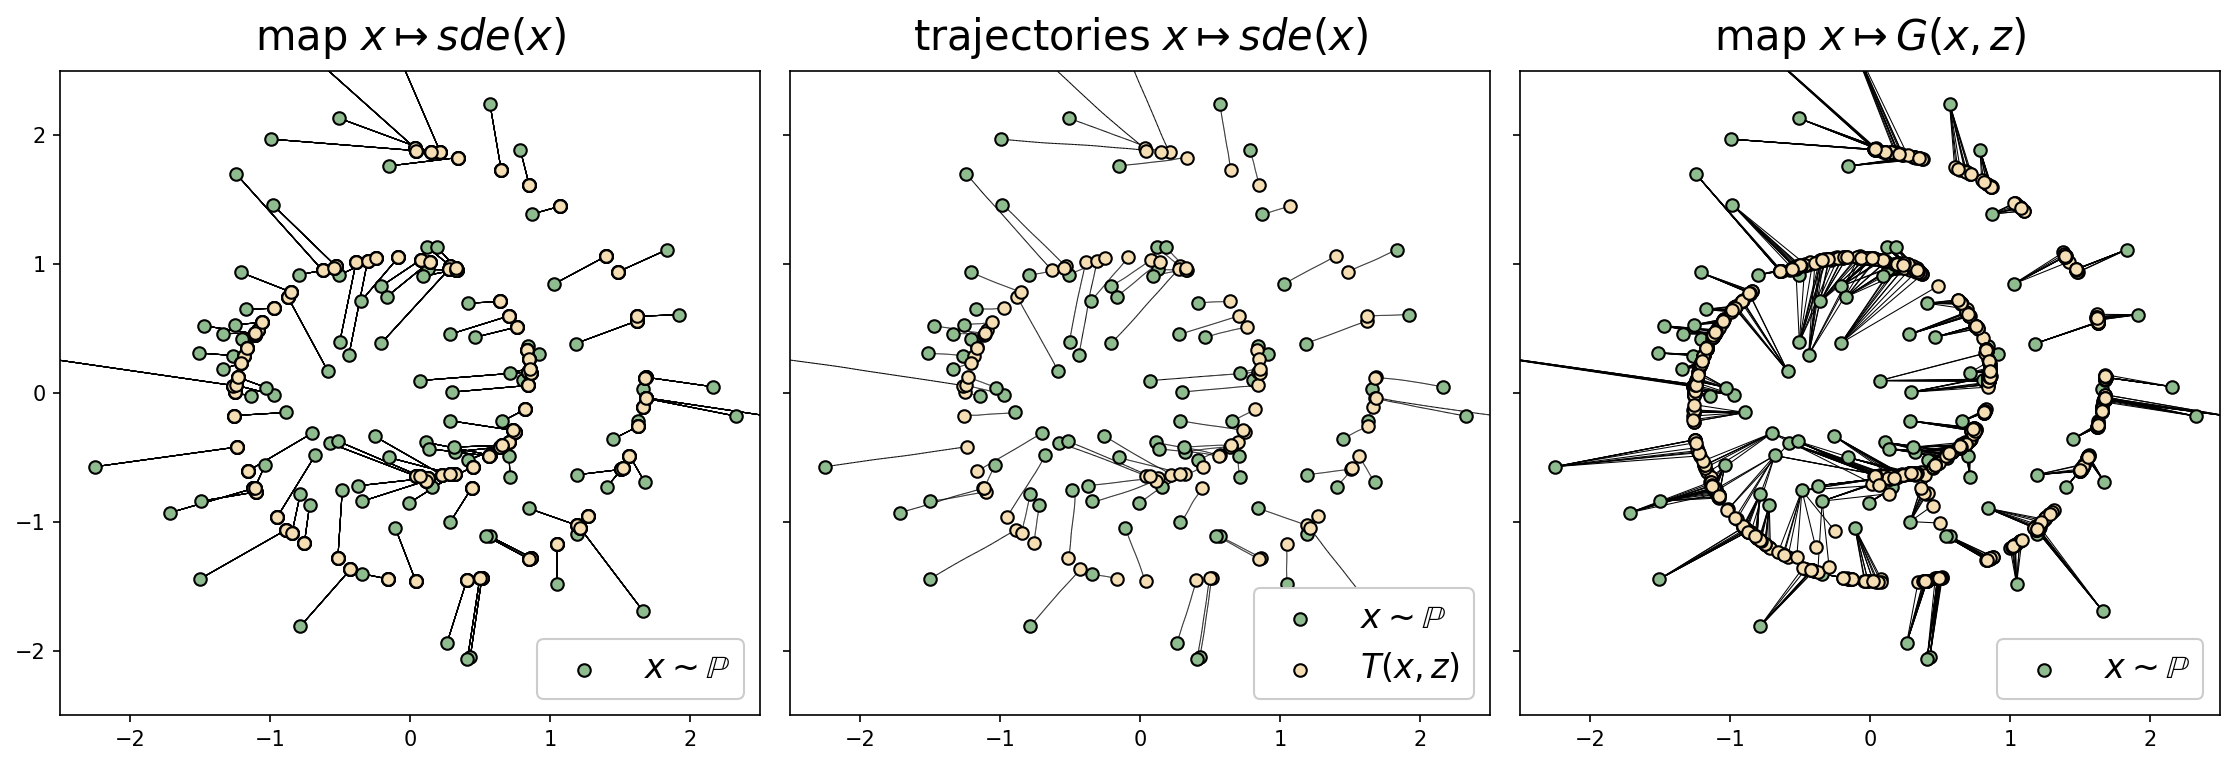

G mse: 0.15303342044353485
sde mse: 0.15176936984062195
G var: 0.004616169258952141
sde var: 4.434467116426477e-13


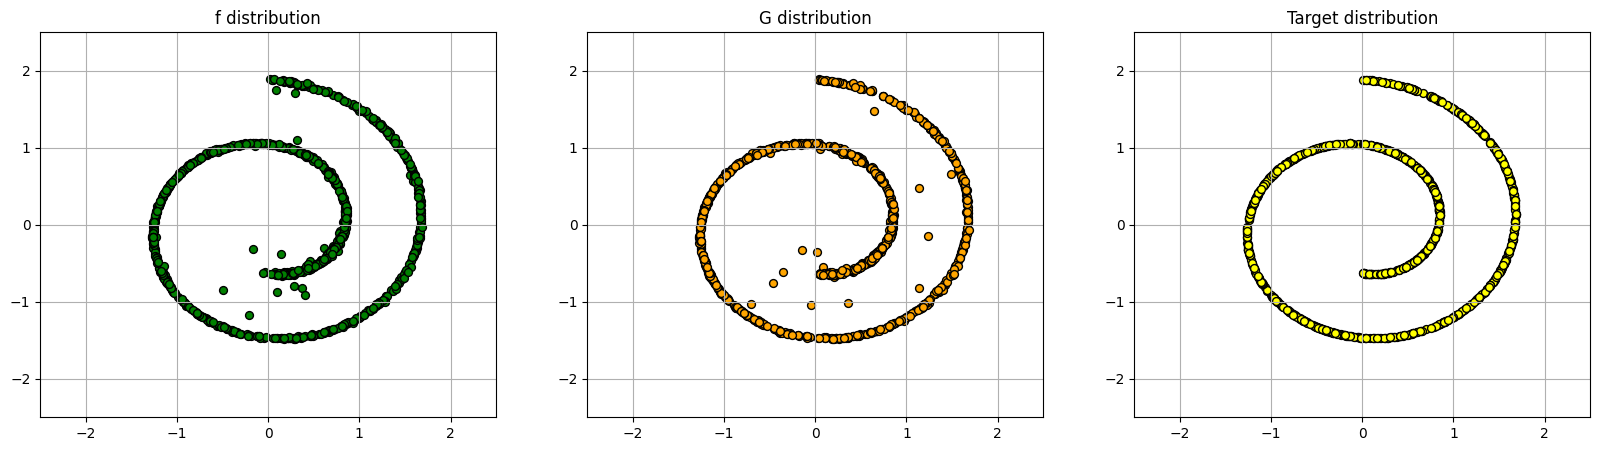

100%|██████████| 5000/5000 [1:13:29<00:00,  1.13it/s]  


In [5]:
sde = SDE(shift_model=f, n_steps=n_steps).cuda()
stats = train(X_sampler, Y_sampler, f, f_opt, G, G_opt, D, D_opt, sde, plot_n_samples=1000)

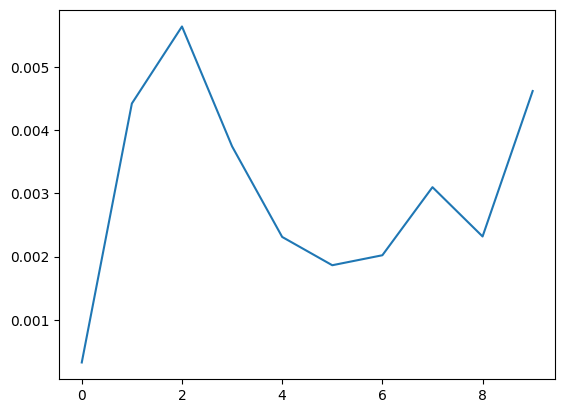

In [6]:
G_mse, G_var, sde_mse, sde_var = stats
plt.plot(np.arange(len(G_var)), np.array(G_var))